In [41]:
import pickle
from gensim.models import word2vec, Word2Vec
import multiprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Layer, Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout, RepeatVector
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KDTree
from sklearn.svm import SVC

from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import adam
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.engine.topology import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn
import nltk
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/dweepa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
dimensions = 300

In [43]:
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import text

In [44]:
with open("./data/mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)
    
atc = [sentence[1][0] for sentence in sentences]
sentences = [sentence[3] for sentence in sentences]

In [45]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sentences)
print("Word Index: ",tokenizer.word_index)

Word Index:  {'3218693969': 1, '3217380708': 2, '951226070': 3, '2245384272': 4, '2968968094': 5, '2246728737': 6, '864942730': 7, '2976033787': 8, '98513984': 9, '864662311': 10, '2246699815': 11, '1510328189': 12, '864674487': 13, '2092489639': 14, '2245273601': 15, '994485099': 16, '10565946': 17, '2041434490': 18, '2117068077': 19, '2803848648': 20, '847961216': 21, '2976816164': 22, '1510461303': 23, '3542456614': 24, '3189457552': 25, '3537119515': 26, '847957139': 27, '1533864325': 28, '2142032900': 29, '1861965050': 30, '266675433': 31, '882399112': 32, '2132511834': 33, '1016841875': 34, '3975275337': 35, '26234434': 36, '2119439498': 37, '2228063684': 38, '848128881': 39, '2246703798': 40, '3452535345': 41, '3818546315': 42, '422715066': 43, '1276993226': 44, '1542633699': 45, '517457164': 46, '864942795': 47, '3537123720': 48, '4121755354': 49, '1135286194': 50, '2245277810': 51, '1535166686': 52, '2076190208': 53, '4008337421': 54, '1100037548': 55, '3351556771': 56, '11019

In [46]:
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = dimensions
wids = [[word2id[w] for w in doc] for doc in sentences]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 2825
Vocabulary Sample: [('3218693969', 1), ('3217380708', 2), ('951226070', 3), ('2245384272', 4), ('2968968094', 5), ('2246728737', 6), ('864942730', 7), ('2976033787', 8), ('98513984', 9), ('864662311', 10)]


In [47]:
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(74537039 (113), 2245384272 (4)) -> 1
(1510328189 (12), 74537039 (113)) -> 1
(2246728737 (6), 1422989759 (2369)) -> 0
(4121755354 (49), 3327193120 (2158)) -> 0
(1510328189 (12), 1583799011 (83)) -> 1
(98513984 (9), 3218693969 (1)) -> 1
(2246728737 (6), 1619222458 (593)) -> 0
(1362518133 (80), 2426197502 (1859)) -> 0
(2245384272 (4), 1510328189 (12)) -> 1
(2968968094 (5), 3789445732 (983)) -> 0


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       847500      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 300, 1)       0           embedding[0][0]                  
__________

/Users/dweepa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


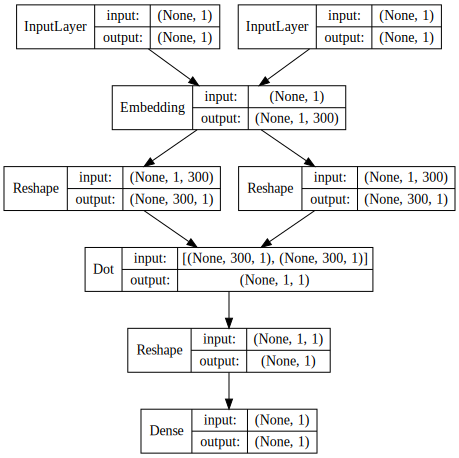

In [48]:
from keras.layers.core import Dense, Reshape
from keras.layers.merge import dot
from keras.layers.embeddings import Embedding
from keras.models import Sequential

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')
word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)

context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model(input=[input_target, input_context], output=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [49]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        try:
            pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
            pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
            labels = np.array(elem[1], dtype='int32')
            X = [pair_first_elem, pair_second_elem]
            Y = labels
            if i % 100 == 0:
                print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
            loss += model.train_on_batch(X,Y)  
        except:
            break
    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 100 (skip_first, skip_second, relevance) pairs
Processed 200 (skip_first, skip_second, relevance) pairs
Processed 300 (skip_first, skip_second, relevance) pairs
Processed 400 (skip_first, skip_second, relevance) pairs
Processed 500 (skip_first, skip_second, relevance) pairs
Processed 600 (skip_first, skip_second, relevance) pairs
Processed 700 (skip_first, skip_second, relevance) pairs
Processed 800 (skip_first, skip_second, relevance) pairs
Processed 900 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 235.78970344364643
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 100 (skip_first, skip_second, relevance) pairs
Processed 200 (skip_first, skip_second, relevance) pairs
Processed 300 (skip_first, skip_second, relevance) pairs
Processed 400 (skip_first, skip_second, relevance) pairs
Processed 500 (skip_first, skip_second, relevance) pairs


In [50]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(2824, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
3218693969,0.028416,0.001319,0.020707,0.035566,0.005566,-0.019669,-0.012383,0.047593,0.066912,0.039028,...,-0.011556,-0.014655,-0.035229,-0.033863,0.006706,-0.036451,-0.024458,0.016003,0.042223,-0.037191
3217380708,-0.003512,0.012672,0.034496,0.043739,0.025192,-0.053766,0.026064,0.017553,0.037273,0.032638,...,0.013635,0.066780,0.020435,-0.074126,-0.013220,-0.039280,-0.015086,0.005892,0.028961,-0.029531
951226070,0.055872,-0.046780,0.003719,0.036046,-0.006804,-0.012654,0.107173,0.003977,0.024670,-0.016880,...,-0.067212,-0.017352,-0.031268,0.034471,0.017391,-0.054848,-0.021533,0.087396,0.077091,-0.042623
2245384272,0.036687,-0.041051,-0.021976,0.024805,0.073658,0.007331,0.090808,0.000259,-0.049594,0.122521,...,-0.064916,-0.019540,0.046939,-0.021957,-0.042474,0.080116,-0.065371,0.026565,0.021167,-0.044639
2968968094,0.067404,-0.063204,0.035266,0.053184,0.009180,-0.038598,-0.060130,0.075598,-0.068664,0.029017,...,-0.017104,-0.025679,0.019351,-0.057040,0.023619,0.024676,-0.026927,-0.015094,0.027308,-0.028619


In [51]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['2246728737','3537119515','2245273601','2423543607']}

similar_words

(2824, 2824)


/Users/dweepa/anaconda/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


{'2245273601': ['98513984',
  '675765711',
  '3537123720',
  '3982076256',
  '517457164'],
 '2246728737': ['3118255683',
  '3776905034',
  '2591432844',
  '98513984',
  '675765711'],
 '2423543607': ['3824347764',
  '2835079913',
  '3772302167',
  '3345225135',
  '2215059400'],
 '3537119515': ['1510461303',
  '98513984',
  '2245384272',
  '485463469',
  '3218693969']}

Total words: 24 	Word Embedding shapes: (24, 300)


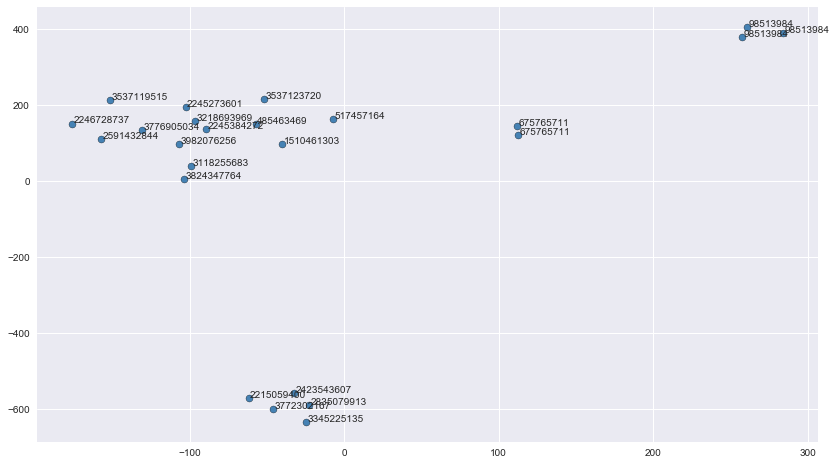

In [52]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [53]:
def getVectors(words, word2id):
    words_ids = [word2id[w]-1 for w in words]
    word_vectors = sum(np.array([weights[idx] for idx in words_ids]))
    return word_vectors

# Vectorization

In [54]:
sum_vectors = []
for sentence in sentences:
    vector = getVectors(sentence, word2id)
    sum_vectors.append(vector)
    
sum_vectors = np.asarray(sum_vectors)

In [55]:
print(sum_vectors.shape)
le = LabelEncoder()
le.fit(atc)
atc = le.transform(atc)

(2731, 300)


## Data Preparation

In [56]:
X = sum_vectors
y = atc

atc_counter = Counter(y)
top_atc = [a for a, _ in atc_counter.most_common(14)]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

atc_labels = le.inverse_transform(np.unique(y))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

## Helper Functions

In [58]:
def accuracy(y_true, y_pred, atc_labels=atc_labels):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True,cbar=False, xticklabels=atc_labels, yticklabels=atc_labels)

# Bi-RNN

In [59]:
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
    
def BiRNNModelAttention(input_shape, output_shape):
    review_input = Input(shape=(input_shape, 1), dtype='float32')
    lstm_sentence = Bidirectional(GRU(100, return_sequences=True))(review_input)
    attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
    preds = Dense(output_shape, activation='softmax')(attn_sentence)
    model = Model(review_input, preds)
    opt = adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
    return model

In [67]:
model = BiRNNModelAttention(dimensions,14)

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300, 200)          61200     
_________________________________________________________________
hierarchical_attention_netwo (None, 200)               20200     
_________________________________________________________________
dense_9 (Dense)              (None, 14)                2814      
Total params: 84,214
Trainable params: 84,214
Non-trainable params: 0
_________________________________________________________________


In [69]:
vec = sum_vectors.reshape(len(sum_vectors),dimensions,1)
X_train, X_test, y_onehot_train, y_onehot_test = train_test_split(vec, y_onehot, test_size=0.3, random_state=int(random.random()*100))

In [70]:
model.fit(X_train, y_onehot_train, epochs=50)

Epoch 1/50
1911/1911 [==============================] - 28s 15ms/step - loss: 2.5046 - acc: 0.1884
Epoch 2/50
1911/1911 [==============================] - 23s 12ms/step - loss: 2.4159 - acc: 0.2062
Epoch 3/50
1911/1911 [==============================] - 24s 12ms/step - loss: 2.4083 - acc: 0.2067
Epoch 4/50
1911/1911 [==============================] - 23s 12ms/step - loss: 2.3952 - acc: 0.2119
Epoch 5/50
1911/1911 [==============================] - 24s 13ms/step - loss: 2.3936 - acc: 0.2104
Epoch 6/50
1911/1911 [==============================] - 24s 12ms/step - loss: 2.3974 - acc: 0.2161
Epoch 7/50
1911/1911 [==============================] - 23s 12ms/step - loss: 2.3888 - acc: 0.2119
Epoch 8/50
1911/1911 [==============================] - 24s 12ms/step - loss: 2.3882 - acc: 0.2104
Epoch 9/50
1911/1911 [==============================] - 25s 13ms/step - loss: 2.3873 - acc: 0.2130
Epoch 10/50
1911/1911 [==============================] - 28s 14ms/step - loss: 2.3832 - acc: 0.2151
Epoch 11/

Overall Accuracy: 0.27195121951219514
              precision    recall  f1-score   support

           0       0.17      0.07      0.10        86
           1       0.00      0.00      0.00        21
           2       0.22      0.41      0.29       108
           3       0.35      0.19      0.25        57
           4       0.31      0.16      0.21        51
           5       1.00      0.09      0.17        11
           6       0.28      0.76      0.41        78
           7       0.09      0.08      0.08        62
           8       0.17      0.18      0.18        44
           9       0.40      0.51      0.45       146
          10       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        58
          12       0.00      0.00      0.00        28
          13       0.30      0.17      0.22        35

   micro avg       0.27      0.27      0.27       820
   macro avg       0.24      0.19      0.17       820
weighted avg       0.23      0.27      0.2

/Users/dweepa/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dweepa/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/dweepa/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


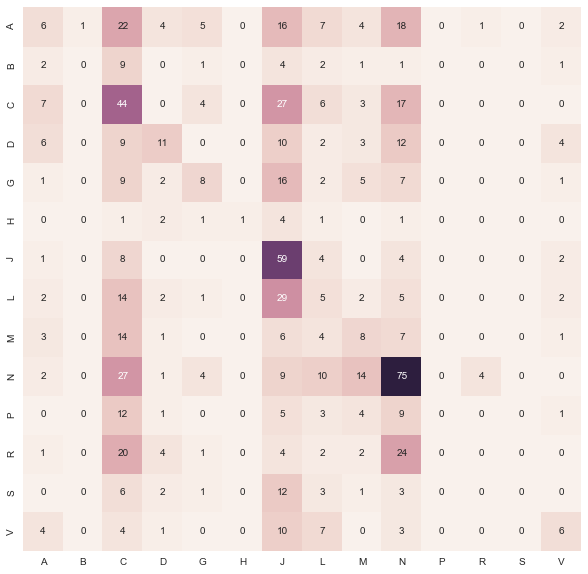

In [71]:
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_onehot_test.argmax(axis=1)
accuracy(y_true, y_pred, atc_labels)